# Introduction to Probabilistic Graphical Models: Practical session 2 - Gaussian Mixture Models 


This notebook is the solution proposed by **[Benjamin LAZARD](https://www.linkedin.com/in/benjaminlazard/)** to *Lab 2* of the course *Introduction to Probabilistic Graphical Models* taught at *Telecom Paristech* by **[Pr. Umut Simsekli](https://perso.telecom-paristech.fr/simsekli/)** (2019 version) in the context of the [Msc data-science](https://datascience-x-master-paris-saclay.fr/), a Master delivered by *Ecole Polytechnique* as part of the **[NewUni](https://www.insidehighered.com/news/2018/06/28/france-considers-plan-create-university-mit)** groupment of universities. 

### References:

0. Pr. Umut Simsekli's course
1. [Gaussian Mixture Models](https://brilliant.org/wiki/gaussian-mixture-model/) (what the algorithm is programmatically)
2. [Expectation-Maximization algorithm](https://www.cs.utah.edu/~piyush/teaching/EM_algorithm.pdf) (what the algorithm is formally, it is more general than GMM)
3. Video course from Andrew NG [1](https://www.youtube.com/watch?v=LBtuYU-HfUg&list=PLA89DCFA6ADACE599&index=12) and [2](https://www.youtube.com/watch?v=LBtuYU-HfUg&list=PLA89DCFA6ADACE599&index=12) (good, but only if you remain highly focused for 1h, and you read the previous stuff).
4. [programming tips](https://github.com/duducheng/clustering_tutorial/blob/master/2_Gaussian_Mixture_and_EM.ipynb) (I found a 1-liner M-step computation for covariances there. Nice work Dudu).
5. [Wrap-up on the clustering ability of GMM](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html)



## What are GMM?

In this lab, we will build from scratch a [Gaussiam Mixture Model (GMM) algorithm](https://brilliant.org/wiki/gaussian-mixture-model/). This algorithm can be used to cluster unlabelled data: it is an *unsupervised learning* technique.

You may have heard before of the [K-means algorithms](https://towardsdatascience.com/clustering-using-k-means-algorithm-81da00f156f6). GMM is an improvement of the later:
- It does not assume the clusters to be "sphericals": it computes "ellipsoids" with a different "radius" for each direction (there are as many directions as there are features for each observation: this is the dimension of the input space).
- It is not deterministic (provide probabilities for affinity to each one of the clusters instead of a "hard" classification).

### Comparing GMM and K-means in 2D
(GMM is on the left, K-means on the right)
![comparison of K_means and GMM](https://ds055uzetaobb.cloudfront.net/image_optimizer/ebf8bda000d3f58a6ac41a28aeefafaae0b021a5.png)

### Visually understanding K-means
![K-means at work](https://cdn-images-1.medium.com/max/800/1*4LOxZL6bFl3rXlr2uCiKlQ.gif)

### Visually understanding GMM
![GMM at work](https://t1.daumcdn.net/cfile/tistory/2035051E4B6405872F)


## Parameters

In our model, each data point $X \in \mathbb{R}^D$ is distributed in the d-dimensionnal space according to a sum of multivariate gaussian laws. In practice in this lab, experiments will be made with $D=2$. We have N such points.

#### Probabilities -> density functions

We will note $\mathbb{P}(X_n = x_n) = p(x_n)$ and $\mathbb{P}(X_1= x_1, ..., X_{N} = x_N) = \mathbb{P}(X_{1:N}= x_{1:N}) = p(x_{1:N})$.


#### Multivariate gaussian Law
$\mathcal{N}\left(x, \mu_i, \Sigma_i\right)$ designates the density function of a multivariate gaussian law with mean $\mu_i$ and covariance matrix $\Sigma_i$ evaluated at point $x$. 

We have $\mathcal{N}\left(x, \mu_i, \Sigma_i\right) = \frac{1}{\sqrt{(2\pi)^D|\boldsymbol\Sigma_i|}}
e^{-\frac{1}{2}({x}-{\mu_i})^T{\boldsymbol\Sigma_i}^{-1}({x}-{\mu_i})}$. 

$\Sigma_i$ is a symmetric semi-definite positive matrix.

#### Sum of gaussians
With this notation, $\forall n \in [0, N-1] \quad p(x_n) = \sum_{k=0}^{K-1}{w_k\mathcal{N}\left(x_n, \mu_k, \Sigma_k\right)}$

$w_k$ is the weight of gaussian k in the model. Notice that it is not dependant from the point $x_n$ only: it is computed for the whole data. In order to make this a density function, we need to achieve: $\sum_{k=0}^{K-1}{w_k}=1$

Because we must have $\int_{\mathbb{R}^D}{p(x_n)dx_n} = 1 \Longleftrightarrow \int_{\mathbb{R}^D}{\left(\sum_{k=0}^{K-1}{w_k\mathcal{N}\left(x_n, \mu_k, \Sigma_k\right)}dx_n\right)} = \sum_{k=0}^{K-1}{w_k\int_{\mathbb{R}^D}{\left(\mathcal{N}\left(x_n, \mu_k, \Sigma_k\right)dx_n\right)}} = 1 \Longleftrightarrow \sum_{k=0}^{K-1}{w_k} = 1$)

**The number of clusters $K$ is an hyper-parameter provided by the user**. There are some techniques like the [Bayesian Information Criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion) which can help choosing the best $K$. [See this example](http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html).

## Algorithm

#### Objective

We want to find the set $\{( w_k, \mu_k, \Sigma_k)\}_{k \in [0, K-1]}$. We find it as the parameter maximizing the probability of obtaining the observations $\{X_n = x_n\}_{n \in [0, N-1]}$ with it.

That is to say: $\{( w_k, \mu_k, \Sigma_k)\}_{k \in [0, K-1]} = \underset{\{( w_k, \mu_k, \Sigma_k)\}_{k \in [0, K-1]}}{\text{argmax}}J(x_{1:n}) = p(x_{1:n} | \{( w_k, \mu_k, \Sigma_k)\}_{k \in [0, K-1]})$

#### EM algorithms

Expectation Maximization Algorithms are a class of algorithms that help computing maximum-likelihood distribution parameterrs. [There is a great formalization available here](https://www.cs.utah.edu/~piyush/teaching/EM_algorithm.pdf). But to summarize it in a few words:

- Let us call $\theta^*$ the optimal batch of parameters $\theta = \{( w_k, \mu_k, \Sigma_k)\}_{k \in [0, K-1]}$ to be found (maximizing $J$).
- This algorithm alledges the existence of hidden vectors of random variables $\{Z\}$ of size $M$ that are explanatory and known/computable by the user. Under total probability law: $p(x_{1:n}|\theta) = \sum_{possible \; Z}{p(x_{1:n}, z_{1:m}|\theta)p(z_{1:m}|\theta)}$
- We will iteratively use knowledge on $Z$ to build a familly of density functions $\{\hat{p}_t\}_{t\leq n\_iter}$ that are lower-bounds of $J(x_{1:n})$. The characteristic of this familly is that at step $t$, the lowerbound function found is equal to $J(x_{1:n})$ on $\theta = \theta_t$ (this is the E-step), we then find their argmax : $\theta_{t+1}$ (M-step), and iterate.
- Convergence $\theta_n \longrightarrow \theta^*$ is guaranteed by the fact at each step, $J(\theta_n)$ is bigger.

To wrap it up formally:

At step **t**:
- E-step: compute $f\left(\theta\right) = \mathbb{E}_{g}\left(p\left(x_{1:N}, z_{1:M} | \theta \right)\right)$ with $g(z_{1:M}) =p\left(z_{1:M} | x_{1:N}, \theta_{t-1}\right)$.
- M-step: $\theta_{t} = \underset{\theta}{\text{argmax}} \; f\left(\theta\right)$



#### GMM particular case


**EM steps applied to GMM**

Here we have $Z \in \mathbb{N}^N$ a prior such that $\mathbb{P}(Z_n = i) = \prod_{k=0}^{K-1}{w_k^{\mathbb{1}_{=k}(z_n)}}$. This is the probability that point $X_n$ belongs to cluster $i$.

##### E-step

If you look at the expression above, the E-step here basically implies the guess of the labels $z_n$ for each data point based on the last $\theta^t$ found (at the previous iteration).

First notice that $p\left(x_{1:N}, z_{1:N} | \theta \right) = \prod_{n=1}^{N}{p(x_n, z_n | \theta)} = \prod_{n=1}^{N}{p(x_n | z_n, \theta)p(z_n | \theta)}$

These terms can be separated with a logarithm (which does not change the argmax value to be found for the M-step of the algorithm as $log$ is a monotonic function).

$ln\left(p\left(x_{1:N}, z_{1:N} | \theta \right)\right) = \sum_{n=1}^{N}{ln\left(p(x_n | \theta, z_n)\right)} + \sum_{n=1}^{N}{ln\left(p(z_n | \theta)\right)} \quad (1)$

We happen to know both distributions:

$ \begin{equation}\begin{split}
p(x_n | \theta, z_n) &= \text{"probability to have point"} x_n \text{"knowing the global distribution of the dataset and its particular cluster"} \\
&= \mathcal{N}\left(x_n, \mu_{z_n}, \Sigma_{z_n}\right) \\
&= \prod_{k=1}^{K}{{\mathcal{N}\left(x_n, \mu_k, \Sigma_k\right)}^{\mathbb{1}_{z_n}(k)}} \\
\end{split}\end{equation} \quad (2)$

$ \begin{equation}\begin{split}
p(z_n | \theta) &= \text{"probability of inclusion in cluster"} z_n \text{"knowing the global distribution of the dataset (independantly from the point)"} \\
&= w_k \\
&= \prod_{k=1}^{K}{{w_k}^{\mathbb{1}_{z_n}(k)}} \\
\end{split}\end{equation} \quad (3)$

Injecting $(2)$ and $(3)$ in $(1)$, and passing to the expectancy we have:

$
\begin{equation}\begin{split}
f(\theta^{t}) 
&= \mathbb{E}_g\left[\sum_{n=1}^{N}{ln\left(p(x_n | \theta, z_n)\right)} + \sum_{n=1}^{N}{ln\left(p(z_n | \theta)\right)}\right] \\
&= \mathbb{E}_g\left[\sum_{n=1}^{N}{ln\left(\prod_{k=1}^{K}{{\mathcal{N}\left(x_n, \mu_k, \Sigma_k\right)}^{\mathbb{1}_{z_n}(k)}}\right)} + \sum_{n=1}^{N}{ln\left(\prod_{k=1}^{K}{{w_k}^{\mathbb{1}_{z_n}(k)}}\right)}\right] \\
&= \mathbb{E}_g\left[\sum_{n=1}^{N}{\sum_{k=1}^{K}{ln\left({\mathcal{N} \left(x_n, \mu_k, \Sigma_k\right)}^{\mathbb{1}_{z_n}(k)}\right)}}+ \sum_{n=1}^{N}{\sum_{k=1}^{K}{ln\left({w_k}^{\mathbb{1}_{z_n}(k)}\right)}}\right] \\
&= \mathbb{E}_g\left[\sum_{n=1}^{N}{\sum_{k=1}^{K}{\mathbb{1}_{z_n}(k) ln\left({\mathcal{N} \left(x_n, \mu_k, \Sigma_k\right)}\right)}}+ \sum_{n=1}^{N}{\sum_{k=1}^{K}{\mathbb{1}_{z_n}(k) ln\left({w_k}\right)}}\right] \\
&= \sum_{n=1}^{N}{\sum_{k=1}^{K}{\mathbb{E}_g\left[\mathbb{1}_{z_n}(k)\right] ln\left({\mathcal{N} \left(x_n, \mu_k, \Sigma_k\right)}\right)}}+ \sum_{n=1}^{N}{\sum_{k=1}^{K}{\mathbb{E}_g\left[\mathbb{1}_{z_n}(k)\right] ln\left({w_k}\right)}}\\
\end{split}\end{equation}$

Let us denote $\gamma_k(x_n) = \gamma_{k, n} = \mathbb{E}_g\left[\mathbb{1}_{z_n}(k)\right]$.
The expectancy of an indicator function isthe probability itself. Because it is computed relatively to the density $g$, we have:

$\gamma_{k, n} = p(z_n=k | x_n, \theta)$

Using the following bayesian decomposition:
$
\begin{equation}\begin{split}
p(x_n, z_n=k | \theta) &= p(z_n=k | x_n, \theta)p(x_n | \theta) & \text{condition on } x_n \\
&= p(x_n | z_n=k, \theta)p(z_n=k | \theta) & \text{condition on } z_n=k \\
\end{split}\end{equation}
$

We have: $\gamma_{k, n} = \frac{p(x_n | z_n=k, \theta)p(z_n=k | \theta)}{p(x_n | \theta)}$. Using the total probability law we get: $\gamma_{k, n} = \frac{p(x_n | z_n=k, \theta)p(z_n=k | \theta)}{\sum_{k=1}^{K}{p(x_n, z_n=k | \theta)}} = \frac{w_k\mathcal{N}\left(x_n, \mu_k, \Sigma_k\right)}{\sum_{k=0}^{K-1}{w_k\mathcal{N}\left(x_n, \mu_k, \Sigma_k\right)}}$

##### M-step

If you solve it to find the argmax of f (under the constraint that $\forall k, w_k>=0$ and $\sum{w_k}=1$) [complicated demo available here](https://www.youtube.com/watch?v=jv2tfR7tyi0&index=122&list=PLD0F06AA0D2E8FFBA), you will find:

- $w_k^{t+1} = \frac{1}{N} \sum_{n=1}^{N}{\gamma_{k, n}^t}$
- $\mu_k^{t+1} = \frac{ \sum_{n=1}^{N}{\gamma_{k, n}^t x_n} }{\sum_{n=1}^{N}{\gamma_{k, n}^t}}$
- $\Sigma_k^{t+1} = \frac{ \sum_{n=1}^{N}{\gamma_{k, n}^t (x_n - \mu_k^t)^T(x_n - \mu_k^t)} }{\sum_{n=1}^{N}{\gamma_{k, n}^t}}$


**Initialization**

0. Pick a value for the number of clusters $K$
1. Initialize $\{\mu_k\}_{k \in [0, K-1]}$ by randomly drawing $K$ values without replacing from $\{X_n\}_{n \in [0, N-1]}$
2. Initialize $\{\Sigma_k\}_{k \in [0, K-1]}$ with the value $\sum_{n=0}^{N-1}{\left(X_i - \bar{X}\right)^2}$ where $\bar{X} = \frac{1}{N}\sum_{n=0}^{N-1}{X_i}$ (or with random covariance matrixes).
3. Initialize $\{w_k\}_{k \in [0, K-1]}$ with the value $\frac{1}{K}$

**Stopping criterion**
- Either when the algorithm converges (we can implement a thresold of variations $\epsilon$ for the norm of covariance matrixes and means below which the algorithm could be considered terminated).
- Or the maximum number of iterations was reached, say `n_iter` (between 10 and 50 in mmy experiments below with 1000 points and 3 clusters)

## Efficiently compute $\gamma_i(x)$

Computing $\gamma_i(x) = \frac{p_i\mathcal{N}\left(x, \mu_i, \Sigma_i\right)}{\sum_{k=0}^{K-1}{w_k\mathcal{N}\left(x, \mu_k, \Sigma_k\right)}}$ is trickier than it seems.

Indeed it might create overflow as throughout the algorithm, the quantities above and below the fraction bar could be rounded to $0.$. In order to avoid this, we will use the logsum trick.

- Compute $l_i = log\left(p_i\mathcal{N}\left(x, \mu_i, \Sigma_i\right)\right) 
= log(p_i) -\frac{N}{2}log(2\pi) - \frac{1}{2} - (x - \mu_i)^T\Sigma^{-1}(x - \mu_i)$
- Then $log(\gamma_i(x)) = l_i - log(\sum{e^{l_j}}) = l_i - max(l_j) - log(\sum{e^{l_j - max(l_j)}})$ where each exponential term is potentially way smaller. This way, we will have a stable computation for very small values.

In [377]:
import numpy as np

####################################
# Utilities
####################################
def log_weighted_normal(w, x, μ, Σ):
    """
    w: weight of the gaussian in th sum-model
    x: point where the distribution is evaluated
    μ: mean
    Σ: covariance matrix
    returns log(w * N(x, μ, Σ)) (weight * multivariate gaussian law)
    """
    normalized_x = x - μ
    inv_Σ = np.linalg.inv(Σ)
    sign, val_log_det_Σ = np.linalg.slogdet(Σ) #robust method (relatively to overflows) computing the log of a matrix
    if(sign < 0):
        print("the covariance matrix has negative determinant")
    exp_prod = np.dot(normalized_x.T, np.dot(inv_Σ, normalized_x))
    n = Σ.shape[0]
    return np.log(w) - n/2.*np.log(2*np.pi) - val_log_det_Σ/2. - exp_prod

def logsum(l_array):
    """
    Computes the log of the sum of exponential terms that are really small values (high negative exponents)
    l_array: the array of exponents 'l' in np.log(np.sum(e**l)))
    returns lmax + np.log(np.sum(e**(l-lmax))) which is equal to np.log(np.sum(e**l))). This is the logsum trick
    """
    l_max = np.max(l_array)
    return l_max + np.log(np.exp(l_array - l_max).sum())

def log_γ(x, w_array, μ_array, Σ_array):
    """
    x: point where the distribution is evaluated
    w_array: array of weights
    μ_array: array of means
    Σ_array: array of covariance matrixes
    returns an array of size K (number of clusters) containing the γ_k(x) as defined above
    """
    K = w_array.shape[0] # number of clusters
    l_array = np.array([log_weighted_normal(w, x, μ, Σ) for (w, μ, Σ) in zip(w_array, μ_array, Σ_array)])
    
    return l_array - logsum(l_array)

def log_likelihood(X, w_array, μ_array, Σ_array):
    """
    returns the global probability of obtaining the Matrix X (N observations x) with the gaussian parameters provided.
    This is J(θ)
    """
    out = 0
    for x in X:
        l_array = np.array([log_weighted_normal(w, x, μ, Σ) for (w, μ, Σ) in zip(w_array, μ_array, Σ_array)])
        out += logsum(l_array)
    return out

####################################
# GMM high-level functions
####################################
def γ_matrix(X, w_array, μ_array, Σ_array):
    """
    X: matrix of observations (N, D). Each line is a D-dimensional point.
    w_array: array of weights
    μ_array: array of means
    Σ_array: array of covariance matrixes
    returns a matrix of size (K, N) containing the γ_k(x_n) as defined above
    """
    N, D = X.shape
    K = w_array.shape[0]
    γ_mat = np.array([np.exp(log_γ(x, w_array, μ_array, Σ_array)) for x in X]).T
    
    # Check there is no overflow:
    ϵ = np.max(np.abs(γ_mat.sum(axis=0) - 1.))
    if ϵ > 1e-10:
        print("there is a problem in the computation of γ")
        return
    
    return γ_mat    

def GMM_EM_step(X, w_array, μ_array, Σ_array):
    """
    EM step in the specific case of GMM algorithms
    X: matrix of observations (N, D). Each line is a D-dimensional point.
    w_array: array of weights
    μ_array: array of means
    Σ_array: array of covariance matrixes
    returns (next_w_array, next_μ_array, next_Σ_array): the parameters of the clusters for the next step
    """
    # Initialize the parameters to return for the next iteration (their shape)
    N, D = X.shape #number of clusters, number of points
    K = w_array.shape[0]
    next_w_array = np.zeros(K)
    next_μ_array = np.zeros((K, D))
    next_Σ_array = np.zeros((K, D, D))
    
    # Compute all the γ_k(x_n) and their sum along N axis,
    γ = γ_matrix(X, w_array, μ_array, Σ_array)
    γ_sum_N = γ.sum(axis=1)
    
    # Compute next_w_array
    next_w_array = γ_sum_N / γ_sum_N.sum()
    
     # Compute next_μ_array, next_Σ_array
    for cluster_index in range(K):
        γ_cluster = γ[cluster_index, :].reshape(-1,1)
        next_μ_array[cluster_index] = (γ_cluster * X).sum(axis=0) / γ_cluster.sum()
        centered_X = X - next_μ_array[cluster_index]
        next_Σ_array[cluster_index] = (centered_X.T).dot(centered_X*γ_cluster) / γ_sum_N[cluster_index]
    
    return next_w_array, next_μ_array, next_Σ_array

## Generating a known training set:

We will create $K =3 $ clusters from the 3 following gaussian distributions:

1. $w_1 = 0.3\quad \mu_1=(0,0)\quad \Sigma_1 = (1.00, −0.25; −0.25, 0.50)$
2. $w_2 = 0.2\quad \mu_2=(1,2)\quad \Sigma_2 = (0.50, 0.25; 0.25, 0.50)$
3. $w_3 = 0.5\quad \mu_3=(2,0)\quad \Sigma_3 = (0.50, −0.25; −0.25, 1)$

Then we will plot the points obtained, so as to show clearly their respective cluster.

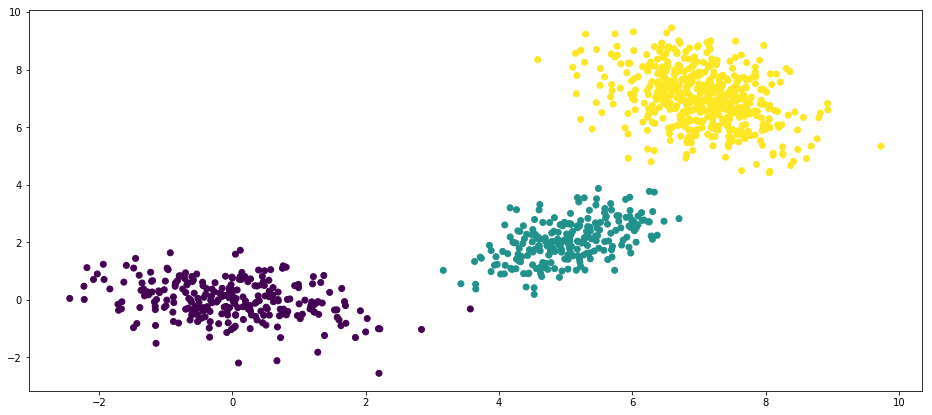

In [378]:
####################################
# Defining the parameters
####################################
w_array_truth = np.array([0.3, 0.2, 0.5])
μ_array_truth = np.array([ [0, 0], [1, 2], [2, 0] ])
# μ_array_truth = np.array([ [0, 0], [5, 2], [7, 7] ])
Σ_array_truth = np.array([
    [[1., -.25], [-.25, .5]],
    [[.5, .25], [.25, .5]],
    [[.5, -.25], [-.25, 1.]]
])

####################################
# Generating and plotting sample data from this distribution
####################################
def generate_data(N=1000, 
                  w_array=w_array_truth, 
                  μ_array=μ_array_truth, 
                  Σ_array=Σ_array_truth
                 ):
    """
    N: number of points to generate
    w_array: array of weights
    μ_array: array of means
    Σ_array: array of covariance matrixes
    returns independant points randomly distributed with the weighted sum of gaussians law
    """
    D = Σ_array[0].shape[0]
    K = w_array.shape[0]
    X = np.zeros((N, D))
    clusters = np.zeros(N, dtype=int)
    for point_index in range(N):
        clusters[point_index] = np.random.choice(K, p=w_array_truth) #pick a cluster
        X[point_index, :] = np.random.multivariate_normal(μ_array[clusters[point_index]], Σ_array[clusters[point_index]])#pick a point with this distribution.
    
    return X, clusters

import matplotlib.pyplot as plt

def plot_data(X, clusters):
    # Check the data is 2D
    if X.shape[1] != 2:
        print("The points represented by X are not 2-dimensional")
        return -1
    # Plot
    plt.figure(figsize=(16,7))
    plt.scatter(X[:,0], X[:,1], c=clusters, cmap = "viridis") # each value of "clusters" is mapped to a different color, with sampling from "veridis" colormap.


X, clusters_truth = generate_data()
plot_data(X, clusters_truth)
plt.show()

Now let us test the computation of the $\gamma_i(x_n)$ (`gamma_matrix` function).
It should:
- produce no errors (yeah I know, I know)
- have non overflowed values (no inf). We can test that by summing along the K axis: the sum of the probabilities that a point belong to a cluster for all cluster is $1$.
- A cluster-matching algorithm created by matching each point to the cluster k for which it has the strongest likelihood $k = \underset{i}{\text{argmax}} \gamma_i(x_n)$ should lead to the same result than the previous picture.

the shape of the γ matrix is: (3, 1000)
the average error is 0.000000e+00
there are 1 missclassified points


[]

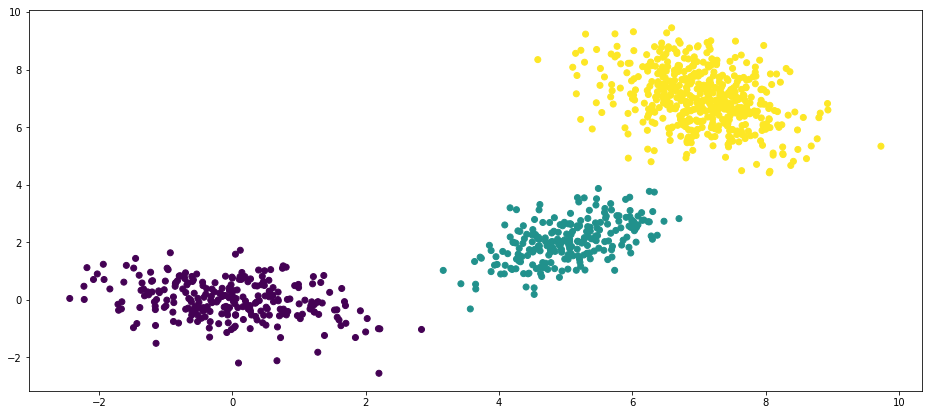

In [379]:
####################################
# γ-based clustering
####################################
def clusterize_with_law(X, w_array, μ_array, Σ_array):
    """
    Based on the parameters of the weighted sum of multivariate gaussians law 
    and a matrix of obervation points,
    matches each point with its "most likely" cluster.
    """
    γ = γ_matrix(X, w_array, μ_array, Σ_array)        
    return γ.argmax(axis=0)

def match_true_labels_2D(X, μ_array_truth, labels):
    """
    A clustering algorithm might lead to a perfect result, yet the name of the clusters
    may not match the names we set for ourselves in the true model ("_array_truth").
    For example our clusters (0,1,2) may be mapped to the model clusters (2,1,0)
    This function corrects this based on euclidian distance between the mean of the clusters in both cases.
    returns: new_labels with consistent naming 
    """
    (N, D) = X.shape
    K = μ_array_truth.shape[0]
    μ_array = np.zeros((K, D))
    
    counts = np.zeros(K)
    for label_index, x in enumerate(X):
        label = labels[label_index]
        counts[label] += 1
        μ_array[label] +=  x
    μ_array /= counts.reshape(-1, 1)
    
    match_labels = np.zeros(K) #the indexes are the labels from labels, the values match the index with the corresponding "true label"
    for k in range(K):
        μ_k = μ_array[k]
        dist = np.array([np.linalg.norm(μ_k - μ_i) for μ_i in μ_array_truth])
        match_labels[k] = np.argmin(dist)
    
    new_labels = np.zeros(N)
    for i in range(N):
        new_labels[i] = match_labels[labels[i]]
        
    return new_labels

####################################
# γ-computation test
####################################
# Shape check
γ_test = γ_matrix(X, w_array_truth, μ_array_truth, Σ_array_truth) 
print("the shape of the γ matrix is:", γ_test.shape)

# The sum along any column should be 1 (the probability that the corresponding datapoint belongs to any of the clusters)
print("the average error is %e"%(γ_test.sum(axis=0).mean()-1.))

# Predict the clusters for each data_point
labels = clusterize_with_law(X, w_array_truth, μ_array_truth, Σ_array_truth)

# Match each cluster with the known ones.
corrected_labels = match_true_labels_2D(X, μ_array_truth, labels)
print("there are %d missclassified points"%((corrected_labels != clusters_truth).sum()))

# Plot
plot_data(X, labels)
plt.plot()

To better visualize the progression of the algorithm, it would be handy to visualize the ellipsoids corresponding to the clustering. I used help from this [tutorial about meshgrid to visualize bivariate gaussian](https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/).

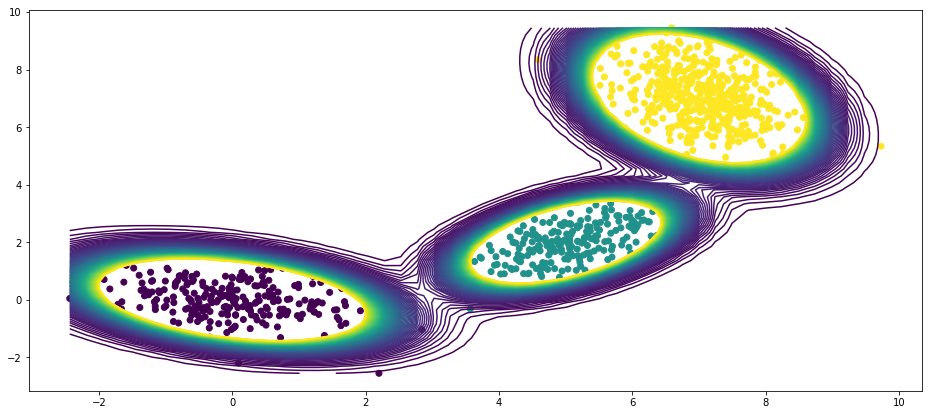

In [380]:
def plot_model_2D(Data, w_array, μ_array, Σ_array):
    K = w_array.shape[0]
    if Data.shape[1] !=2:
        print("The data is not 2-dimensional")
        return
    
    ########################## Prepare data for the plot
    # Define the boundaries of the plot based on the data extrama points.
    min_x, max_x, min_y, max_y = np.min(Data[:,0]), np.max(Data[:,0]), np.min(Data[:,1]), np.max(Data[:,1])
    n = 50 # precision of the grid (how many points to be drawn on each axis)
    X, Y = np.meshgrid(np.linspace(min_x, max_x, n), np.linspace(min_y, max_y, n))
    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    
    ########################## Define a bivariate gaussian distribution function compatible with meshgrid
    # https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/
    def multivariate_gaussian(pos, μ, Σ):
        """
        Return the multivariate Gaussian distribution on array pos.
        pos is an array constructed by packing the meshed arrays of variables
        x_1, x_2, x_3, ..., x_k into its _last_ dimension.
        """
        n = μ.shape[0]
        Σ_det = np.linalg.det(Σ)
        Σ_inv = np.linalg.inv(Σ)
        N = np.sqrt((2*np.pi)**n * Σ_det)
        # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
        # way across all the input variables.
        fac = np.einsum('...k,kl,...l->...', pos-μ, Σ_inv, pos-μ)

        return np.exp(-fac / 2) / N
    
    ########################## Compute the total density function at any given point pos in R²
    def density(pos, w_array, μ_array, Σ_array):
        val = 0
        for cluster_index in range(K):
            w, μ, Σ = w_array[cluster_index], μ_array[cluster_index], Σ_array[cluster_index]
            val +=  w * multivariate_gaussian(pos, μ, Σ)
        return val
    
    ########################## Draw level lines
    Z = density(pos, w_array, μ_array, Σ_array)
    # Do not create a new figure as we want it to be superposed to the previous one.
    levels = np.arange(0., 0.01, 0.0001) # will emphasize the tail f the gaussian (the contour)
    plt.contour(X, Y, Z, levels=levels)

plot_data(X, corrected_labels)
plot_model_2D(X, w_array_truth, μ_array_truth, Σ_array_truth)
plt.show()

Now let us implement the genuine GMM algorithm using the functions we have created so far.

## GMM implementation

there are 1 missclassified points


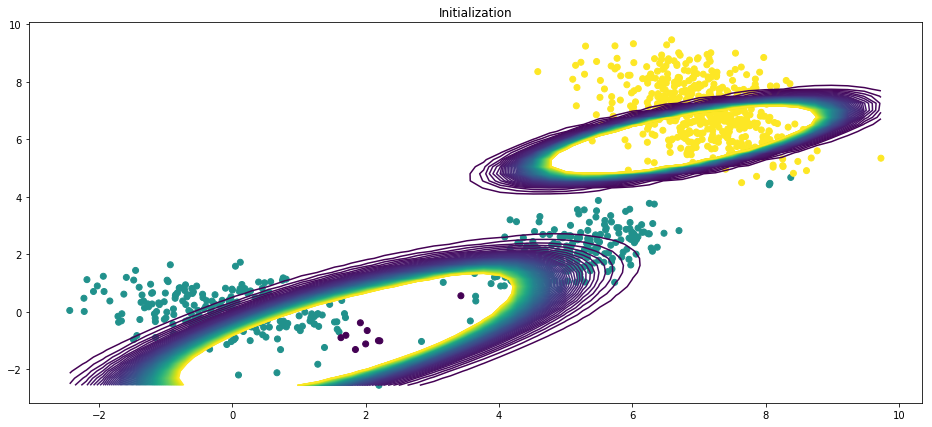

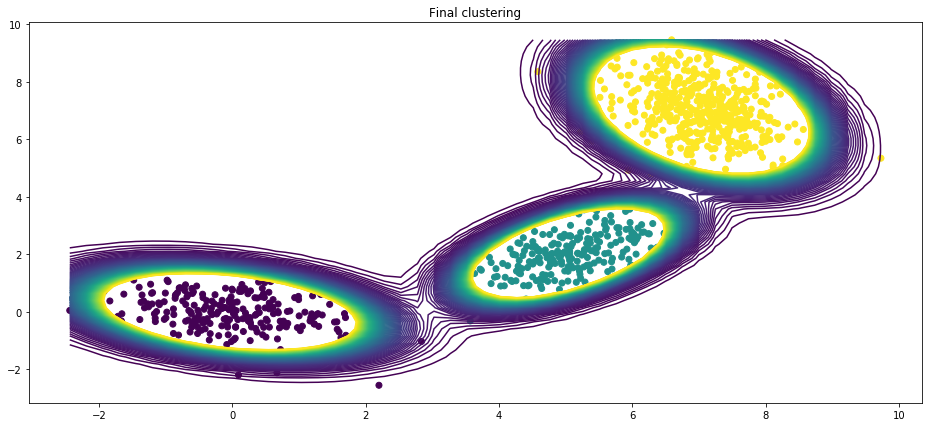

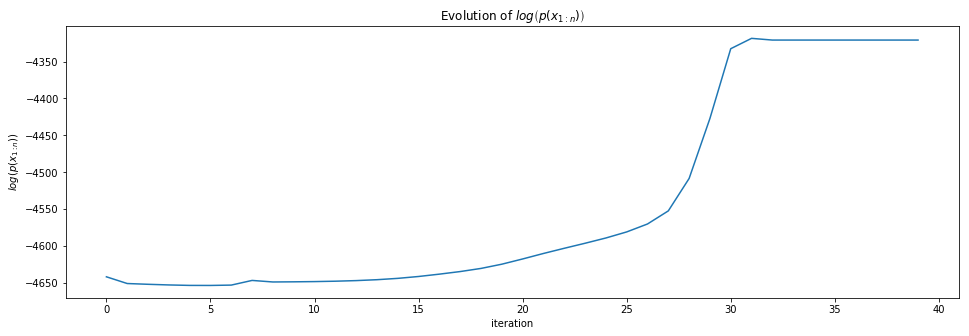

In [381]:
def GMM_init(X, K=3):
    """
    returns initial weights, means and covariances to start the GMM algorithms
    """
    (N, D) = X.shape
    
    # Initialization
    random_points_indexes = np.random.choice(N, size=K, replace=False)
    μ_array = X[random_points_indexes]
    w_array = np.ones(K) / float(K)
    
    # generate random covariates
    Σ_array = []
    for cluster_index in range(K):
        s = np.random.rand(D, D)
        Σ_array.append(np.dot(s, s.T))    
    Σ_array = np.array(Σ_array)
    
    return w_array, μ_array, Σ_array
    

def GMM(X, K=3, n_iter=12, init=GMM_init(X, K=3)):
    """
    The complete GMM algorithm.
    returns the history of log-likelihoods,
            the history of means, 
            the history of covariances,
            the history of weights 
    found at each step.
    """
    
    w_array, μ_array, Σ_array = init
    
    # Keep a history of the parameters history and log-likelihoods (function to minimize)
    w_array_hist = np.zeros((n_iter, K))
    μ_array_hist = np.zeros((n_iter, K, D))
    Σ_array_hist = np.zeros((n_iter, K, D, D))
    log_likelihood_hist = np.zeros(n_iter)
    
    # Perform the EM-steps
    for step in range(n_iter):
        
        # Compute the EM step
        w_array, μ_array, Σ_array = GMM_EM_step(X, w_array, μ_array, Σ_array)
        labels = clusterize_with_law(X, w_array, μ_array, Σ_array)
        
        #Compute the log_likelihood
        ll = log_likelihood(X, w_array, μ_array, Σ_array)
        
        # Keep the history in memory
        w_array_hist[step], μ_array_hist[step], Σ_array_hist[step], log_likelihood_hist[step] = w_array, μ_array, Σ_array, ll
    
    return w_array_hist, μ_array_hist, Σ_array_hist, log_likelihood_hist

####################################
# Perform the prediction
####################################

############## Initialization

# To show you a random case where it worked, I already exectuted the function below and hard-coded the output
# (w_array_init, μ_array_init, Σ_array_init) = GMM_init(X, K=3)

w_array_init = np.array([0.33333333, 0.33333333, 0.33333333])
μ_array_init =  np.array([[ 2.29562083, -0.49000686],
                          [ 1.60082678, -0.89042886],
                          [ 6.76034605,  5.97288494]])
Σ_array_init = np.array([[[0.44036316, 0.35551317],
                          [0.35551317, 0.43805925]],
                         
                         [[1.57342776, 0.91038725],
                          [0.91038725, 0.99340938]],
                         
                         [[0.67029289, 0.27611982],
                          [0.27611982, 0.2251258 ]]])

############## Final Prediction
w_array_predicted_hist, μ_array_predicted_hist, Σ_array_predicted_hist, log_likelihood_hist = GMM(X, 
                                                                                                  K=3, 
                                                                                                  n_iter=40, 
                                                                                                  init=(w_array_init, 
                                                                                                        μ_array_init, 
                                                                                                        Σ_array_init)
                                                                                                 )
w_array_predicted, μ_array_predicted, Σ_array_predicted = w_array_predicted_hist[-1], μ_array_predicted_hist[-1], Σ_array_predicted_hist[-1]
labels_predicted = clusterize_with_law(X, w_array_predicted, μ_array_predicted, Σ_array_predicted)
corrected_labels_predicted = match_true_labels_2D(X, μ_array_truth, labels_predicted)
print("there are %d missclassified points"%((corrected_labels_predicted != clusters_truth).sum()))


##############  Plot the result of the clustering with the initialization parameters
labels_init = clusterize_with_law(X, w_array_init, μ_array_init, Σ_array_init)
plot_data(X, labels_init)
plot_model_2D(X, w_array_init, μ_array_init, Σ_array_init)
plt.title("Initialization")
plt.show()

##############  Plot the result of the clustering algorithm
plot_data(X, corrected_labels_predicted)
plot_model_2D(X, w_array_predicted, μ_array_predicted, Σ_array_predicted)
plt.title("Final clustering")
plt.show()

##############  Plot the evolution of log-likelihood
plt.figure(figsize=(16,5))
plt.plot(log_likelihood_hist)
plt.title(r"Evolution of $log\left(p(x_{1:n})\right)$")
plt.xlabel("iteration")
plt.ylabel(r"$log\left(p(x_{1:n})\right)$")
plt.show()

## Impact of initialization parameters

In GMM, the choice of the points initializing the algorithm is really important, as you can see below.
To avoid this, one can perform first the K-means algorithm, and use the centers centers to initialize the means of the gaussians, and the variance of each cluster to initialize the covariance matrixes.

there are 235 missclassified points


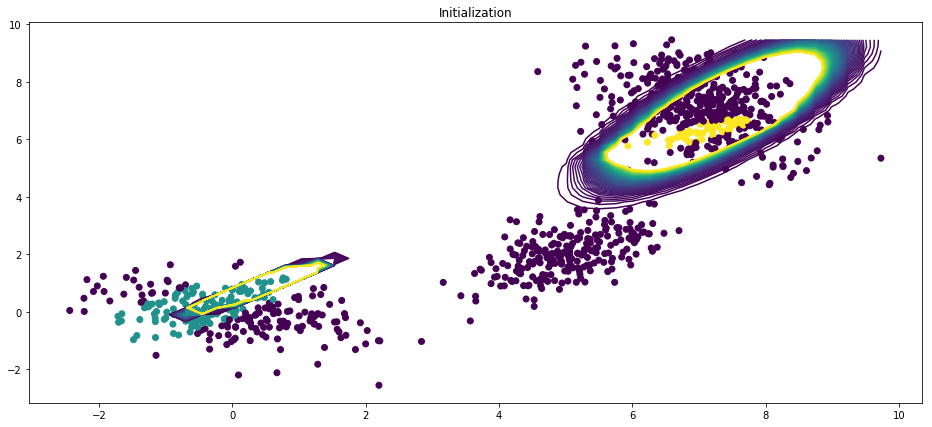

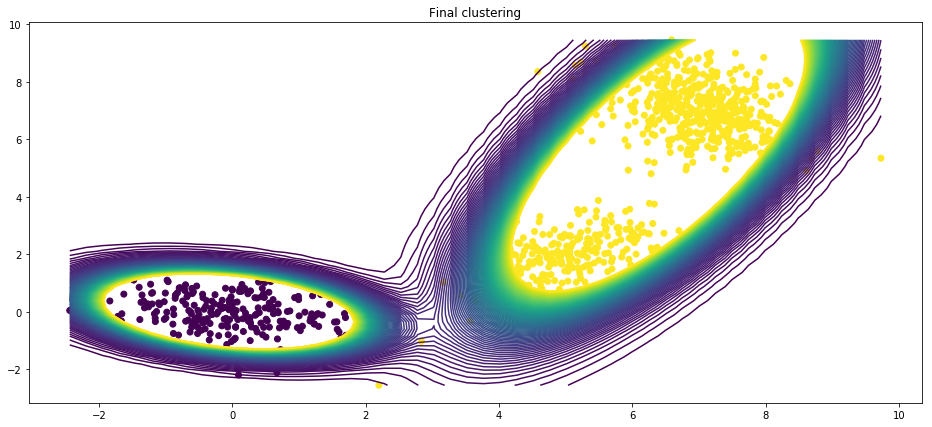

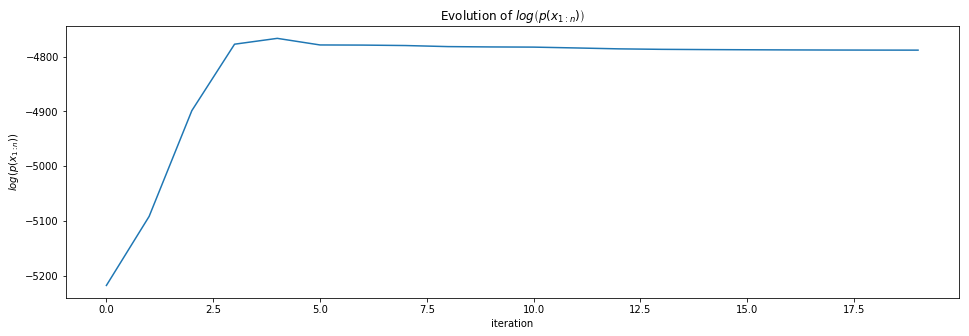

In [382]:
# To show you a random case where it does not work, I already exectuted the function below and hard-coded the output
# (w_array_init, μ_array_init, Σ_array_init) = GMM_init(X, K=3)

w_array_init = np.array([0.33333333, 0.33333333, 0.33333333])
μ_array_init = np.array([[7.35091853, 6.96504448],
                         [0.32801744, 0.81344517],
                         [6.96640594, 6.25299683]])
Σ_array_init = np.array([[[0.40468664, 0.43841001], [0.43841001, 0.78169576]],
                         [[0.08788631, 0.07400769], [0.07400769, 0.0663429 ]], 
                         [[0.19800645, 0.1244964 ], [0.1244964 , 0.12117483]]])

############## Final Prediction
w_array_predicted_hist, μ_array_predicted_hist, Σ_array_predicted_hist, log_likelihood_hist = GMM(X, 
                                                                                                  K=3, 
                                                                                                  n_iter=20, 
                                                                                                  init=(w_array_init, 
                                                                                                        μ_array_init, 
                                                                                                        Σ_array_init)
                                                                                                 )
w_array_predicted, μ_array_predicted, Σ_array_predicted = w_array_predicted_hist[-1], μ_array_predicted_hist[-1], Σ_array_predicted_hist[-1]
labels_predicted = clusterize_with_law(X, w_array_predicted, μ_array_predicted, Σ_array_predicted)
corrected_labels_predicted = match_true_labels_2D(X, μ_array_truth, labels_predicted)
print("there are %d missclassified points"%((corrected_labels_predicted != clusters_truth).sum()))

##############  Plot the result of the clustering with the initialization parameters
labels_init = clusterize_with_law(X, w_array_init, μ_array_init, Σ_array_init)
plot_data(X, labels_init)
plot_model_2D(X, w_array_init, μ_array_init, Σ_array_init)
plt.title("Initialization")
plt.show()

##############  Plot the result of the clustering algorithm
plot_data(X, corrected_labels_predicted)
plot_model_2D(X, w_array_predicted, μ_array_predicted, Σ_array_predicted)
plt.title("Final clustering")
plt.show()

##############  Plot the evolution of log-likelihood
plt.figure(figsize=(16,5))
plt.plot(log_likelihood_hist)
plt.title(r"Evolution of $log\left(p(x_{1:n})\right)$")
plt.xlabel("iteration")
plt.ylabel(r"$log\left(p(x_{1:n})\right)$")
plt.show()

## Impact of the clusters nature

What if the clusters are superposed?

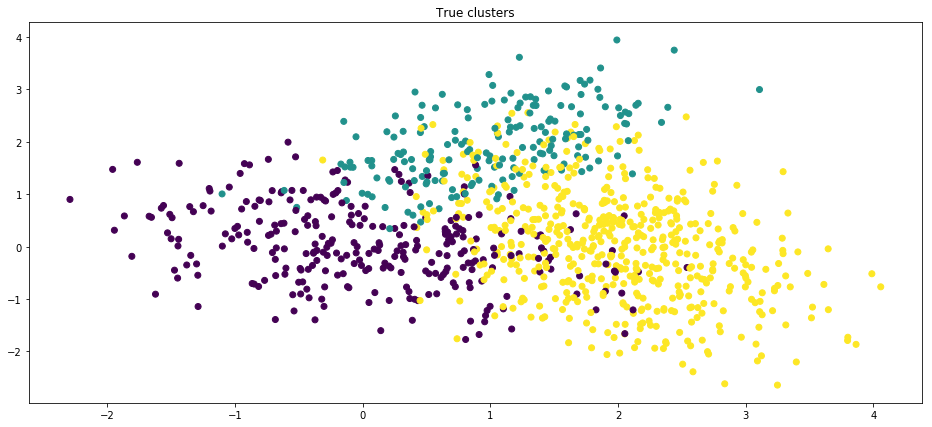

there are 435 missclassified points


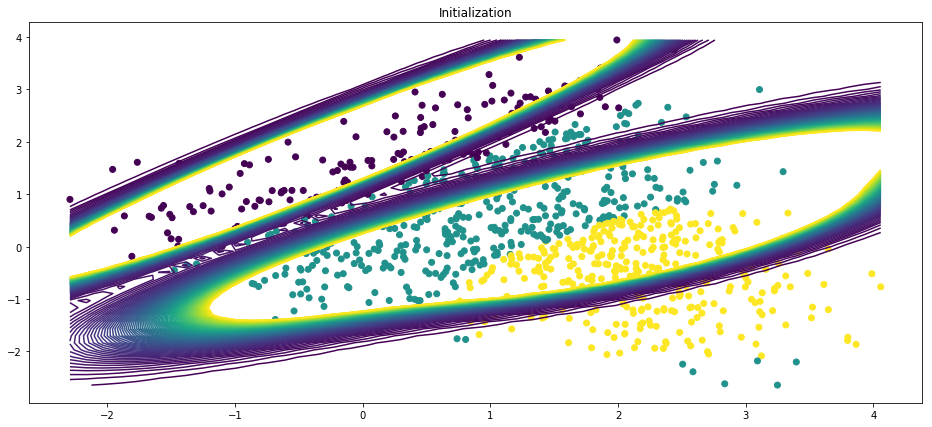

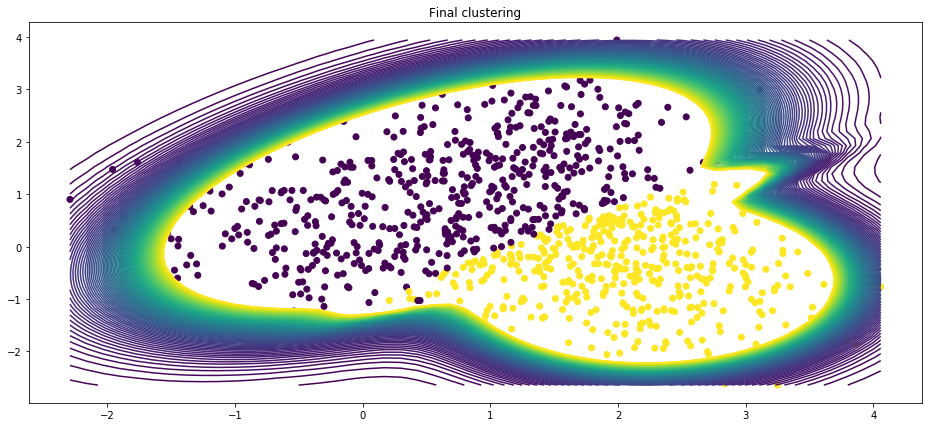

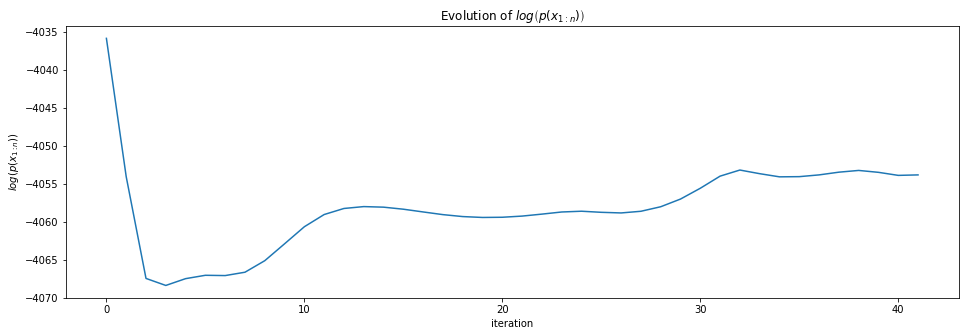

In [402]:
####################################
# Defining other parameters (superposition of clusters)
####################################
w_array_truth = np.array([0.3, 0.2, 0.5])
μ_array_truth = np.array([ [0, 0], [1, 2], [2, 0] ])
Σ_array_truth = np.array([
    [[1., -.25], [-.25, .5]],
    [[.5, .25], [.25, .5]],
    [[.5, -.25], [-.25, 1.]]
])

X, clusters_truth = generate_data(1000, w_array_truth, μ_array_truth, Σ_array_truth)
plot_data(X, clusters_truth)
plt.title("True clusters")
plt.show()

############## Initialization
# (w_array_init, μ_array_init, Σ_array_init) = GMM_init(X, K=3)
(w_array_init, μ_array_init, Σ_array_init) = (np.array([0.33333333, 0.33333333, 0.33333333]),
 np.array([[-0.28424324,  1.72161175],
        [ 1.51747667,  0.40785936],
        [ 2.05861657,  0.21013894]]),
 np.array([[[0.99391604, 0.94756534],
         [0.94756534, 0.98287284]],
 
        [[1.55325412, 0.90897135],
         [0.90897135, 0.6879555 ]],
 
        [[0.48297527, 0.22830558],
         [0.22830558, 0.21163916]]]))


############## Final Prediction
w_array_predicted_hist, μ_array_predicted_hist, Σ_array_predicted_hist, log_likelihood_hist = GMM(X, 
                                                                                                  K=3, 
                                                                                                  n_iter=42, 
                                                                                                  init=(w_array_init, 
                                                                                                        μ_array_init, 
                                                                                                        Σ_array_init)
                                                                                                 )
w_array_predicted, μ_array_predicted, Σ_array_predicted = w_array_predicted_hist[-1], μ_array_predicted_hist[-1], Σ_array_predicted_hist[-1]
labels_predicted = clusterize_with_law(X, w_array_predicted, μ_array_predicted, Σ_array_predicted)
corrected_labels_predicted = match_true_labels_2D(X, μ_array_truth, labels_predicted)
print("there are %d missclassified points"%((corrected_labels_predicted != clusters_truth).sum()))

##############  Plot the result of the clustering with the initialization parameters
labels_init = clusterize_with_law(X, w_array_init, μ_array_init, Σ_array_init)
plot_data(X, labels_init)
plot_model_2D(X, w_array_init, μ_array_init, Σ_array_init)
plt.title("Initialization")
plt.show()

##############  Plot the result of the clustering algorithm
plot_data(X, corrected_labels_predicted)
plot_model_2D(X, w_array_predicted, μ_array_predicted, Σ_array_predicted)
plt.title("Final clustering")
plt.show()

##############  Plot the evolution of log-likelihood
plt.figure(figsize=(16,5))
plt.plot(log_likelihood_hist)
plt.title(r"Evolution of $log\left(p(x_{1:n})\right)$")
plt.xlabel("iteration")
plt.ylabel(r"$log\left(p(x_{1:n})\right)$")
plt.show()

I ran the algorithm several times, and noticed that there's always one cluster that seem to fade away with a random start.